## Remapping models fields on 1°x1° grid without land-sea masks using xESMF

Different algorithms are available:

Bilinear and conservative (need corners) should be the most commonly used methods. They are both monotonic (i.e. will not create new maximum/minimum).
Nearest neighbour methods, either source to destination (s2d) or destination to source (d2s), could be useful in special cases. Keep in mind that d2s is highly non-monotonic.
Patch is ESMF's unique method, producing highly smooth results but quite slow.

Detailed explanations are available on ESMPy documentation (https://xesmf.readthedocs.io/en/latest/why.html)

Can choose conservative remapping only if there are lat bounds and lon bounds in the model file to remap
In general conservative remapping is used to remap from VHR to LR

### Choose kernel gloenv_py3.10

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from netCDF4 import Dataset
import numpy as np
import math
import xarray as xr
import xesmf as xe
import pandas as pd
import time as t
import os
import shutil

In [2]:
begin = t.time()

In [3]:
method_list = [
    "conservative",
    "bilinear",
    "nearest_s2d",
    "nearest_d2s",
    "patch",
]
method=method_list[1]
print("Remapping :"+method)

Remapping :bilinear


In [4]:
# Useful functions
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def get_lon_name(ds):
    for lon_name in ['lon', 'longitude']:
        if lon_name in ds.coords:
            return lon_name
    raise RuntimeError("Couldn't find a longitude coordinate")
    
def get_lat_bounds(ds):
    for vname in ['lat_bounds', 'lat_bnds']:
        if lat_bounds in ds.data_vars:
            return lat_bounds
    raise RuntimeError("Couldn't find a lat bounds variable in the file")
    
def get_lon_bounds(ds):
    for vname in ['lon_bounds', 'lon_bnds']:
        if lon_bounds in ds.data_vars:
            return lon_bounds
    raise RuntimeError("Couldn't find a lon bounds variable in the file")

In [5]:
institute='CNRM-CERFACS'
model='CNRM-CM6-1'
mip='ScenarioMIP'
table='Amon'
m_first='r1i1p1f2'
ipf='i1p1f2'
grid='gr'
dir_in='/data/scratch/globc/dcom/CMIP6/'
dir_model=str(mip)+'/'+str(institute)+'/'+str(model)+'/'
#scenarios=['ssp126','ssp245','ssp370','ssp585']
scenarios=['ssp126']
#vars_in = ['ua','va']
vars_in = ['ua']
dir_out='/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/'

In [6]:
shutil.rmtree(dir_out+model)
os.mkdir(dir_out+model)

In [7]:
var_target_grid = xr.open_dataset('/data/scratch/globc/dcom/CMIP6_TOOLS/xESMF_Interpolation/tavg_BEST_1deg.nc')

In [8]:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], var_target_grid[get_lat_name(var_target_grid)].values),
        "lon": (["lon"], var_target_grid[get_lon_name(var_target_grid)].values),
    }
)
ds_out

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    *empty*

In [9]:
# créer la grille pour le conservative (avec les bounds)
ds_out = xe.util.grid_2d(
    -180., 180, 1, -90, 90, 1  # longitude & latitude range and resolution
) 
ds_out

<xarray.Dataset>
Dimensions:  (y: 180, x: 360, y_b: 181, x_b: 361)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon_b    (y_b, x_b) float64 -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 ... 90 90 90 90 90 90
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

In [10]:
var_for_regridder =  xr.open_mfdataset(dir_in+dir_model+scenarios[0]+'/'+m_first+'/'+table+'/'+vars_in[0]+'/'+grid+'/latest/*.nc')

In [11]:
if method == "conservative":
    ds_in = xr.Dataset(
    {
        "lat": (["lat"], var_for_regridder[get_lat_name(var_for_regridder)].values),
        "lon": (["lon"], var_for_regridder[get_lon_name(var_for_regridder)].values),
        "lat_b": (["lat_b"], var_for_regridder[get_lat_bounds(var_for_regridder)].values),
        "lon_b": (["lon_b"], var_for_regridder[get_lon_bounds(var_for_regridder)].values),
    }
    )
    ds_in
else:
    ds_in = xr.Dataset(
    {
        "lat": (["lat"], var_for_regridder[get_lat_name(var_for_regridder)].values),
        "lon": (["lon"], var_for_regridder[get_lon_name(var_for_regridder)].values),
    }
    )
    ds_in

### Remapping : calculate the weights 

In [12]:
regridder = xe.Regridder(ds_in, ds_out, method, periodic=True)
regridder  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_128x256_180x360_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (128, 256) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

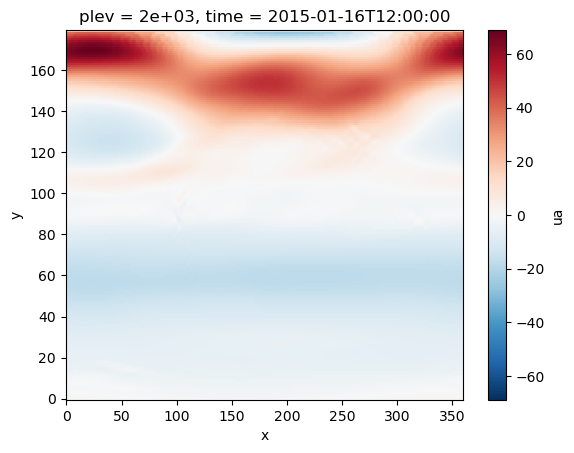

In [19]:
var_interp = regridder(var_for_regridder)
var_interp
var=var_interp.sel(plev=2000)
var
var[vars_in[0]].isel(time=0).plot()

### Then apply the weights

Be carefull member is different from a model to another

In [14]:
for scenario in scenarios:
    for var_in in vars_in:
        for i in range(1): 
            member='r'+str(i+1)+ipf
            var = xr.open_mfdataset(dir_in+dir_model+str(scenario)+'/'+member+'/'+table+'/'+str(var_in)+'/gr/latest/*.nc')
            var_interp = regridder(var)
            var_interp.to_netcdf(path=dir_out+'/'+model+'/'+str(var_in)+'_'+str(scenario)+'_'+member+'_'+str(method)+'_'+model+'-1deg.nc', mode='w')

In [15]:
end = t.time()
print('Runtime to calculate the weights is', '{0:.1f}'.format(end - begin), 's')

Runtime to calculate the weights is 125.1 s
